In [14]:
### Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
from scipy.fftpack import fft, fftfreq
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.filters.hp_filter import hpfilter
import pywt

df = pd.read_excel("/Users/elvinanosrati/Capstone/energy-production-analysis/Amberd.xlsx")

In [15]:
print(df.head())
print(df.columns)


        Date      Time  Hour Index  Energy Production (kWh)  Station
0 2022-01-01  01:00:00           1                   182.28  Amberd1
1 2022-01-01  02:00:00           2                   183.12  Amberd1
2 2022-01-01  03:00:00           3                   179.76  Amberd1
3 2022-01-01  04:00:00           4                   178.92  Amberd1
4 2022-01-01  05:00:00           5                   179.76  Amberd1
Index(['Date', 'Time', 'Hour Index', 'Energy Production (kWh)', 'Station'], dtype='object')


In [16]:
df["DateTime"] = pd.to_datetime(df["Date"].astype(str) + " " + df["Time"].astype(str), errors="coerce")

df.set_index("DateTime", inplace=True)
df.drop(columns=["Date", "Time"], inplace=True)
df.drop(columns=["Hour Index"], inplace=True)

df["Energy Production (kWh)"] = pd.to_numeric(df["Energy Production (kWh)"], errors="coerce")
df["Energy Production (kWh)"] = df["Energy Production (kWh)"].interpolate(method="linear")

df_daily = df.groupby("Station").resample("D").sum(numeric_only=True)
df_daily.reset_index(level=0, inplace=True)  # Keep Station as a column, but keep DateTime as index

df_residuals = pd.DataFrame(index=df_daily.index)
df_residuals["Station"] = df_daily["Station"]

df_residuals["STL_Residuals"] = np.nan
df_residuals["Diff_Residuals"] = np.nan
df_residuals["HP_Residuals"] = np.nan
df_residuals["Fourier_Residuals"] = np.nan
df_residuals["Wavelet_Residuals"] = np.nan

In [17]:
print(df_daily.head())  
print(df_daily.columns)

             Station  Energy Production (kWh)
DateTime                                     
2022-01-01  Amberd 3                 12693.38
2022-01-02  Amberd 3                 13652.38
2022-01-03  Amberd 3                 12507.04
2022-01-04  Amberd 3                 14888.44
2022-01-05  Amberd 3                 13641.18
Index(['Station', 'Energy Production (kWh)'], dtype='object')


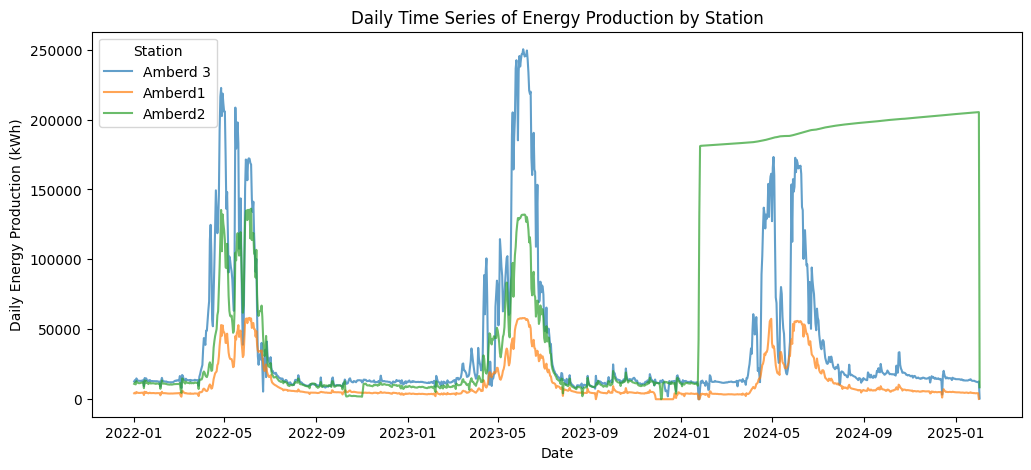

In [6]:
### Time Series Visualization
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_daily, x="DateTime", y="Energy Production (kWh)", hue="Station", alpha=0.7)

plt.title("Daily Time Series of Energy Production by Station")
plt.xlabel("Date")
plt.ylabel("Daily Energy Production (kWh)")
plt.legend(title="Station")

plt.show()

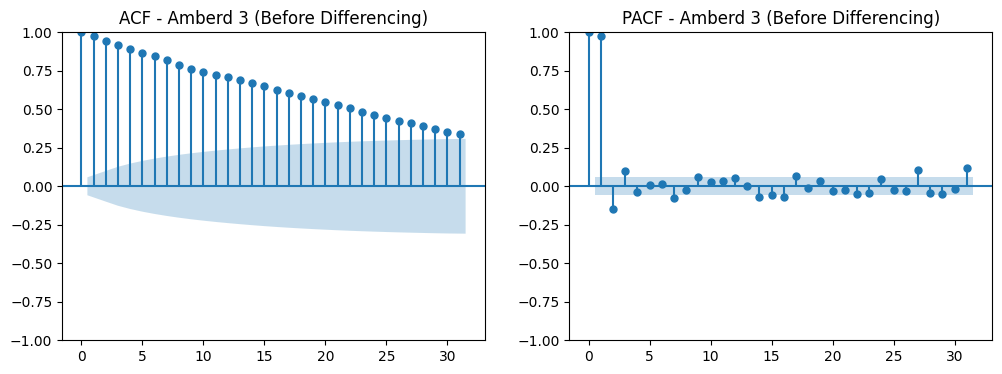

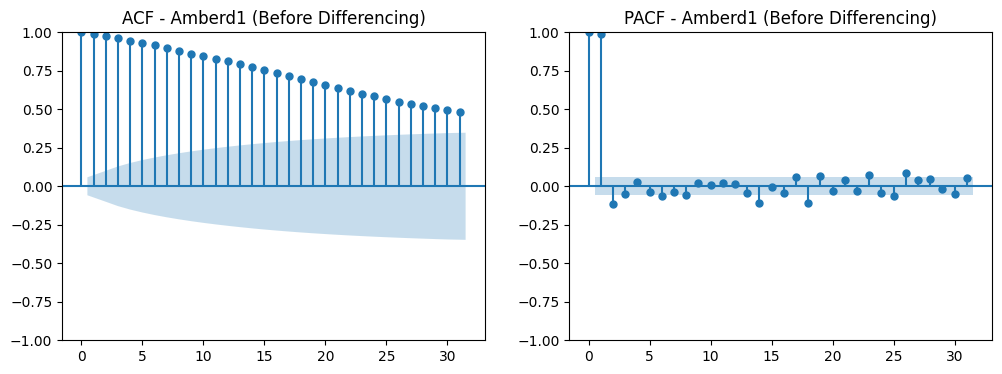

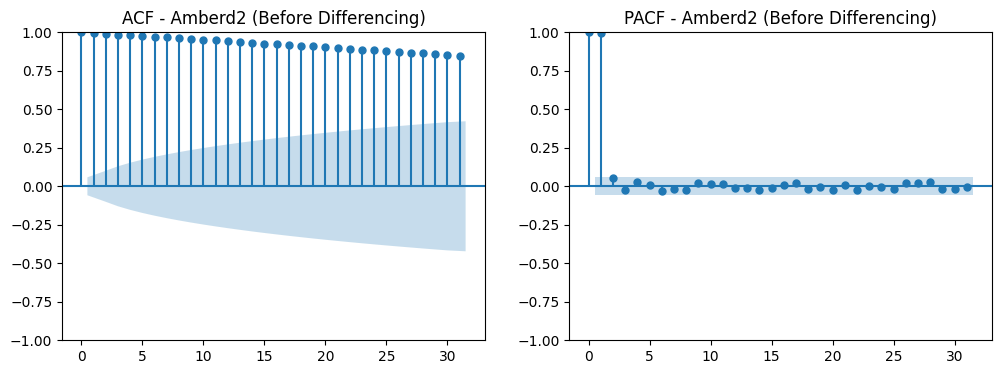

In [7]:
### ACF and PACF Plots (Before Differencing)
for station in df_daily["Station"].unique():
    station_data = df_daily.loc[df_daily["Station"] == station, "Energy Production (kWh)"].dropna()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(station_data, ax=axes[0], title=f"ACF - {station} (Before Differencing)")
    plot_pacf(station_data, ax=axes[1], title=f"PACF - {station} (Before Differencing)")
    plt.show()


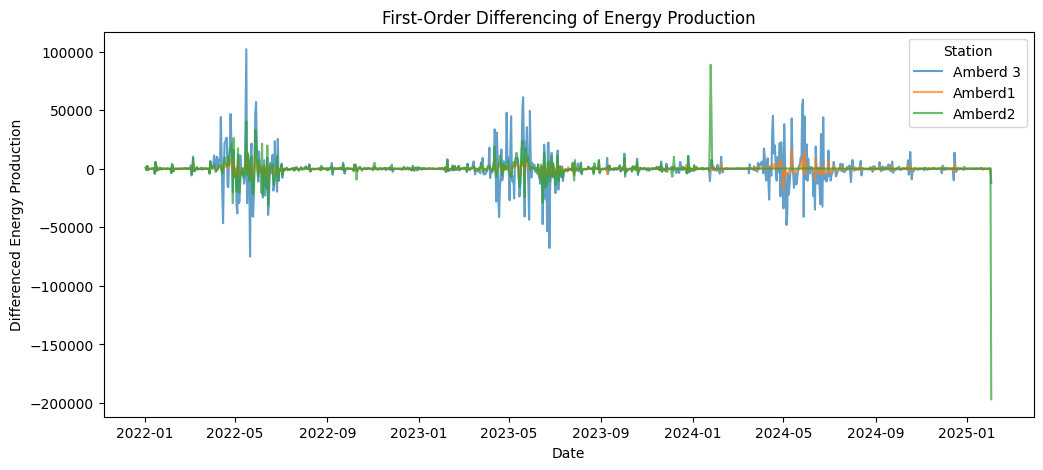

In [8]:
###Apply First-Order Differencing on `df_daily`
df_daily["Diff_Production"] = df_daily.groupby("Station")["Energy Production (kWh)"].diff()
df_residuals["Diff_Residuals"] = df_daily["Diff_Production"]

df_daily.dropna(subset=["Diff_Production"], inplace=True)

plt.figure(figsize=(12, 5))
sns.lineplot(data=df_daily, x="DateTime", y="Diff_Production", hue="Station", alpha=0.7)
plt.title("First-Order Differencing of Energy Production")
plt.xlabel("Date")
plt.ylabel("Differenced Energy Production")
plt.legend(title="Station")
plt.show()

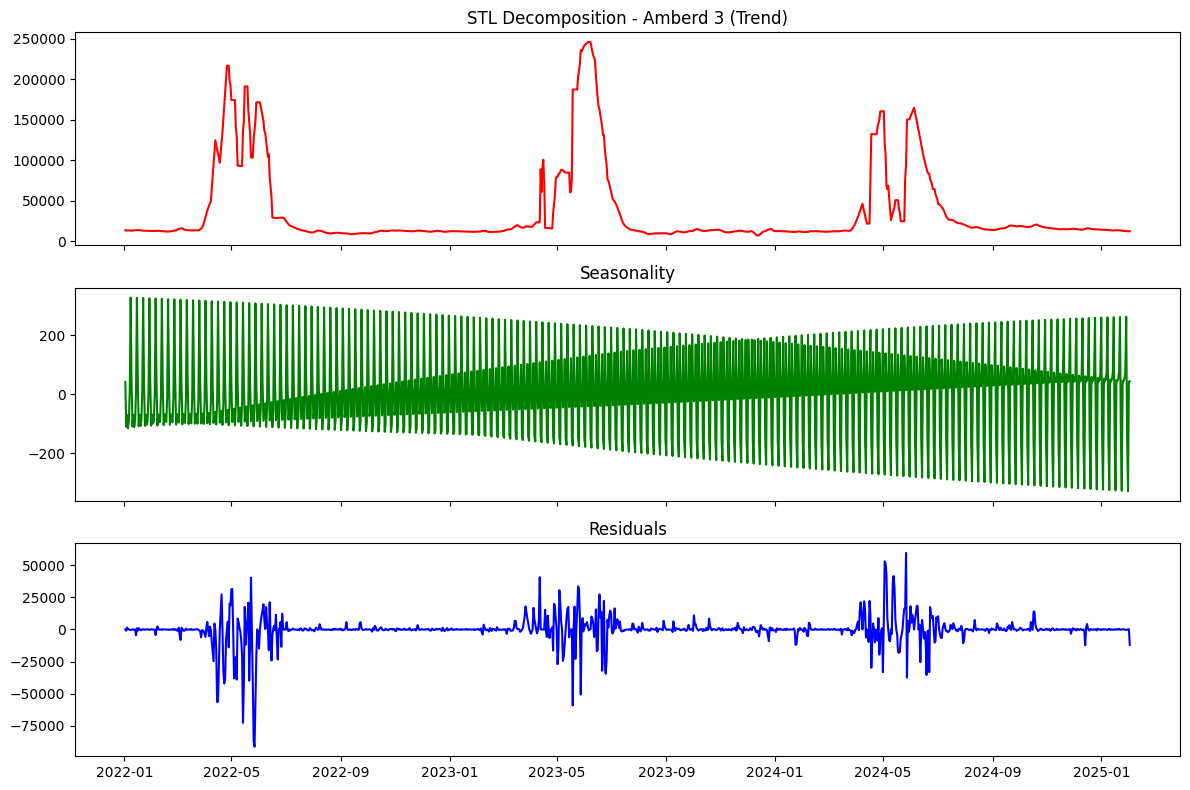

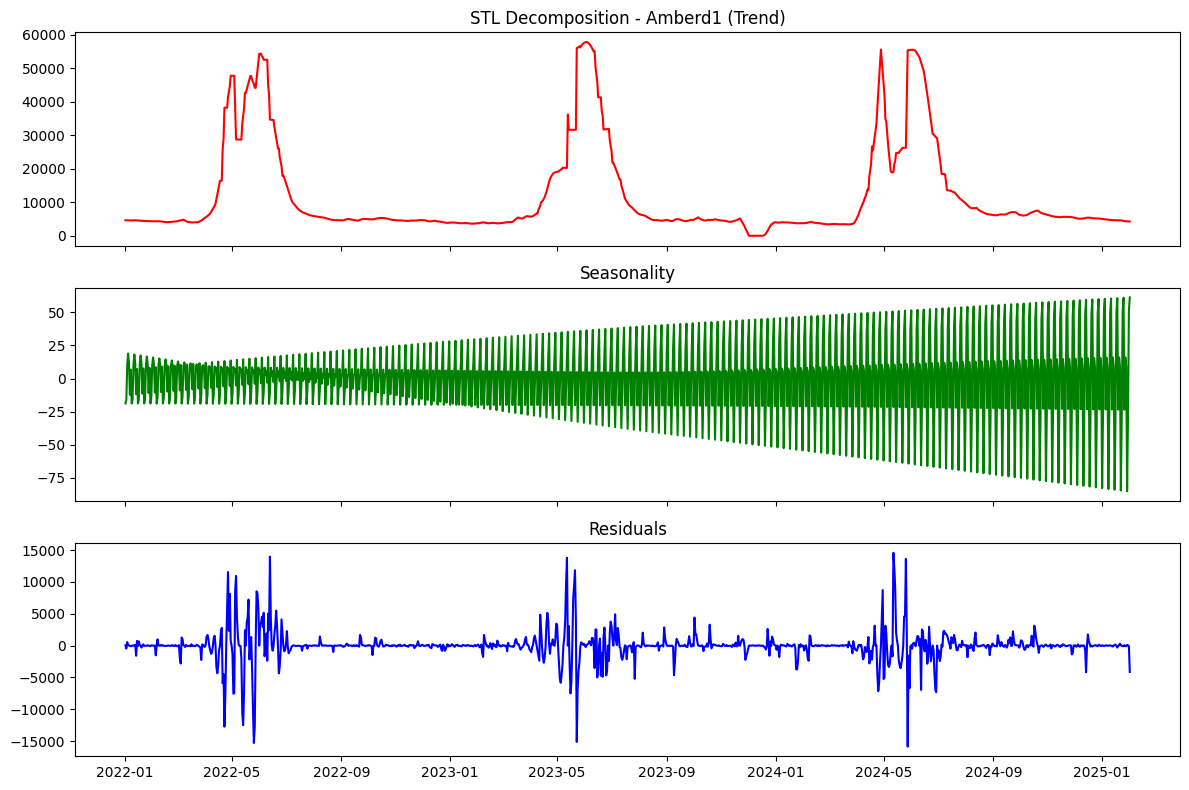

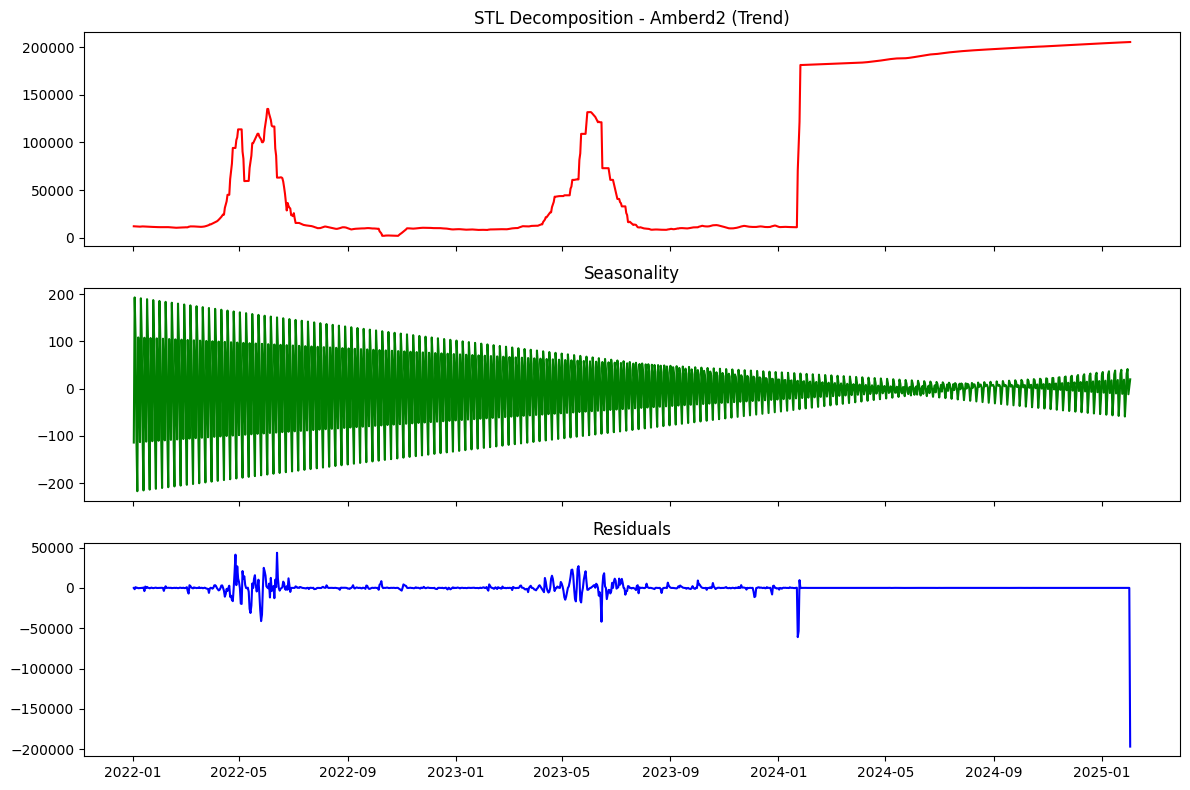

In [9]:
# STL Decomposition for each station
for station in df_daily["Station"].unique():
    station_data = df_daily[df_daily["Station"] == station]["Energy Production (kWh)"].copy()
    
    station_data = station_data.sort_index()
    
    stl = STL(station_data, seasonal=365, robust=True)
    result = stl.fit()

    residuals = result.resid
    residuals.index = station_data.index  # Explicitly set index

    for date in residuals.index:
        df_residuals.loc[(df_residuals.index == date) & (df_residuals["Station"] == station), "STL_Residuals"] = residuals.loc[date]

    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    
    axes[0].plot(result.trend, label="Trend", color="red")
    axes[0].set_title(f"STL Decomposition - {station} (Trend)")
    
    axes[1].plot(result.seasonal, label="Seasonality", color="green")
    axes[1].set_title("Seasonality")
    
    axes[2].plot(result.resid, label="Residuals", color="blue")
    axes[2].set_title("Residuals")

    plt.tight_layout()

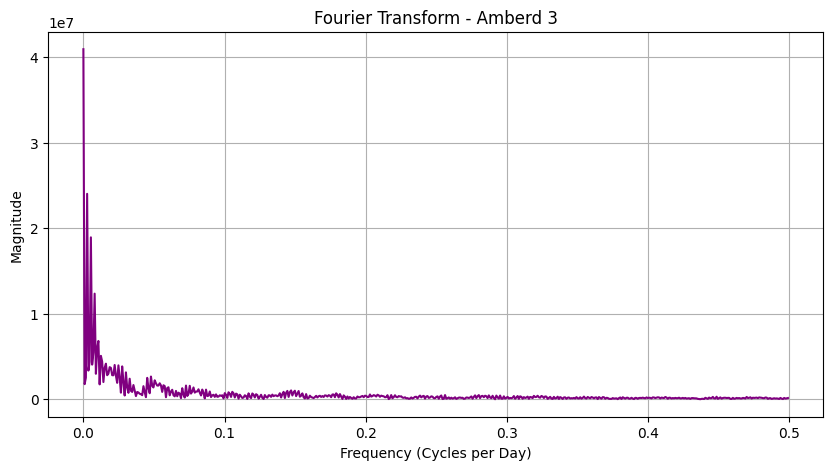

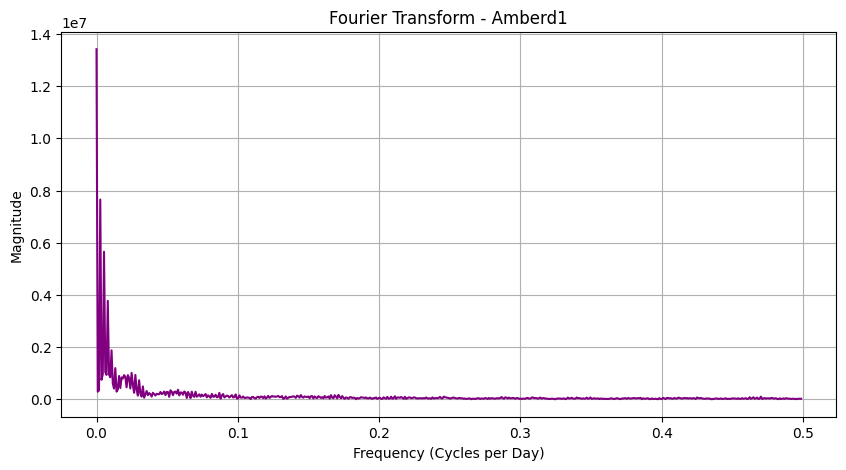

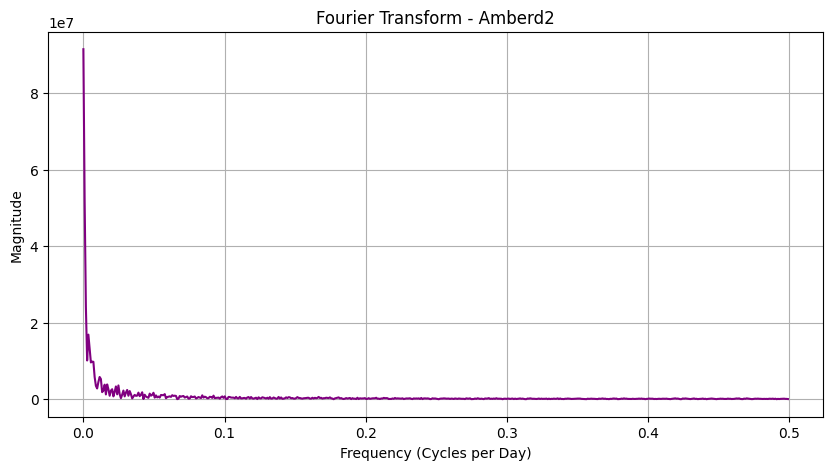

In [10]:
### Fourier Transform (Using Daily Data)
for station in df_daily["Station"].unique():
    station_data = df_daily[df_daily["Station"] == station]["Energy Production (kWh)"].dropna()

    N = len(station_data)
    T = 1  # Assuming daily frequency (1 day per sample)
    
    fft_result = fft(station_data.values)
    frequencies = fftfreq(N, T)

    # Keep only positive frequencies
    positive_freqs = frequencies[:N // 2]
    magnitude = np.abs(fft_result[:N // 2])

    # Store Fourier residuals (Aligning with df_residuals)
    inverse_fft = np.fft.ifft(fft_result).real  # Convert back to real values

    # Ensure correct index alignment
    fourier_residuals_series = pd.Series(inverse_fft, index=station_data.index)

    # Store in df_residuals (Only update matching indices)
    df_residuals.loc[df_residuals["Station"] == station, "Fourier_Residuals"] = (
        fourier_residuals_series.reindex(df_residuals[df_residuals["Station"] == station].index).values
    )

    # Plot FFT Spectrum
    plt.figure(figsize=(10, 5))
    plt.plot(positive_freqs, magnitude, color='purple')
    plt.title(f"Fourier Transform - {station}")
    plt.xlabel("Frequency (Cycles per Day)")
    plt.ylabel("Magnitude")
    plt.grid()
    plt.show()





/Users/elvinanosrati/jupyter_env/lib/python3.13/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


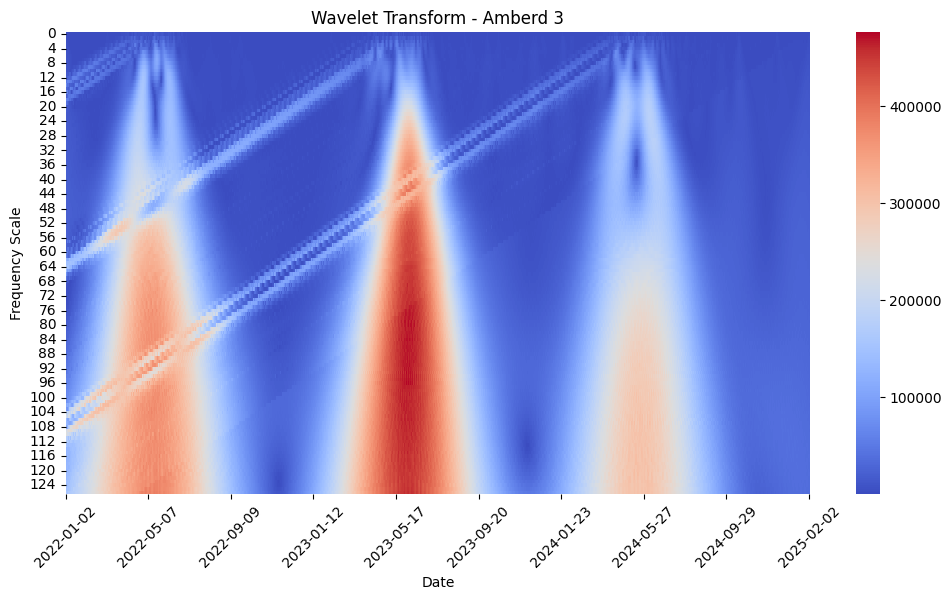

/Users/elvinanosrati/jupyter_env/lib/python3.13/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


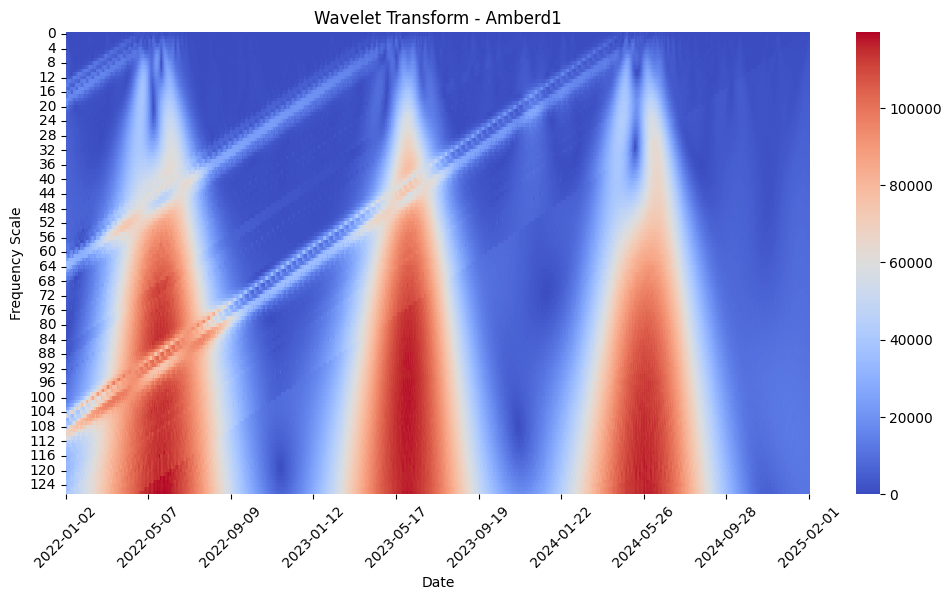

/Users/elvinanosrati/jupyter_env/lib/python3.13/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


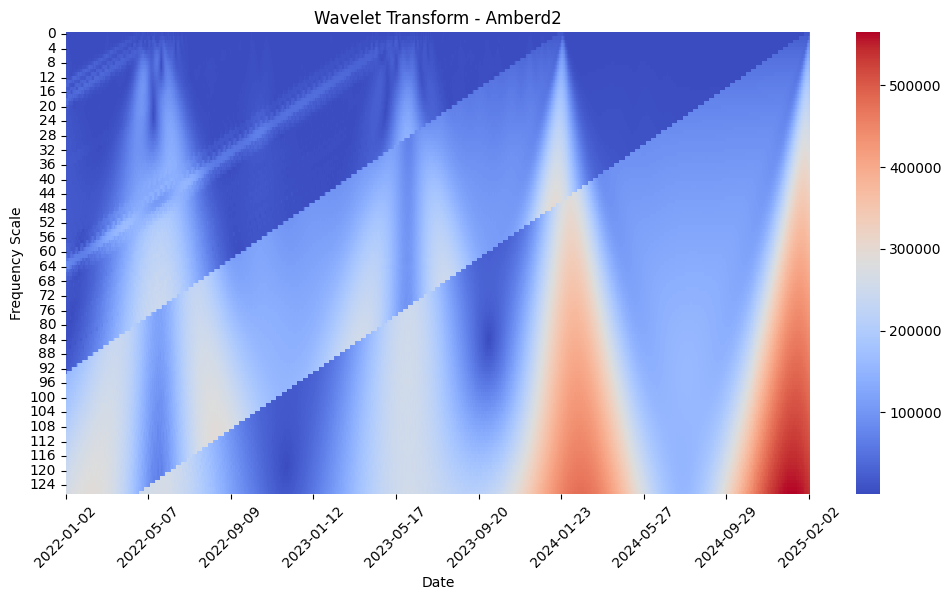

In [11]:
### Wavelet Transform 
for station in df_daily["Station"].unique():
    station_data = df_daily[df_daily["Station"] == station]["Energy Production (kWh)"].dropna()

    station_data = station_data.sort_index()

    scales = np.arange(1, 128)  
    wavelet_name = "cmor"  

    coefficients, frequencies = pywt.cwt(station_data, scales, wavelet_name)

    wavelet_residuals = coefficients[-1, :].real  
    wavelet_residuals_series = pd.Series(wavelet_residuals, index=station_data.index)

    df_residuals.loc[df_residuals["Station"] == station, "Wavelet_Residuals"] = (
        wavelet_residuals_series.reindex(df_residuals[df_residuals["Station"] == station].index).values
    )

    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(np.abs(coefficients), cmap="coolwarm", cbar=True)

    num_ticks = min(len(station_data), 10) 
    tick_positions = np.linspace(0, len(station_data) - 1, num=num_ticks).astype(int)
    tick_labels = station_data.index[tick_positions].strftime("%Y-%m-%d")  

    plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)

    plt.title(f"Wavelet Transform - {station}")
    plt.xlabel("Date")
    plt.ylabel("Frequency Scale")
    plt.show()

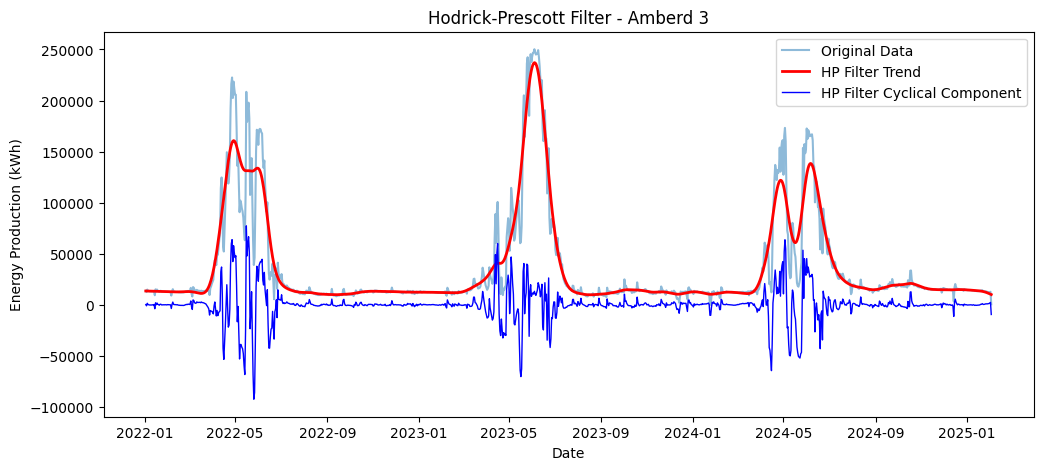

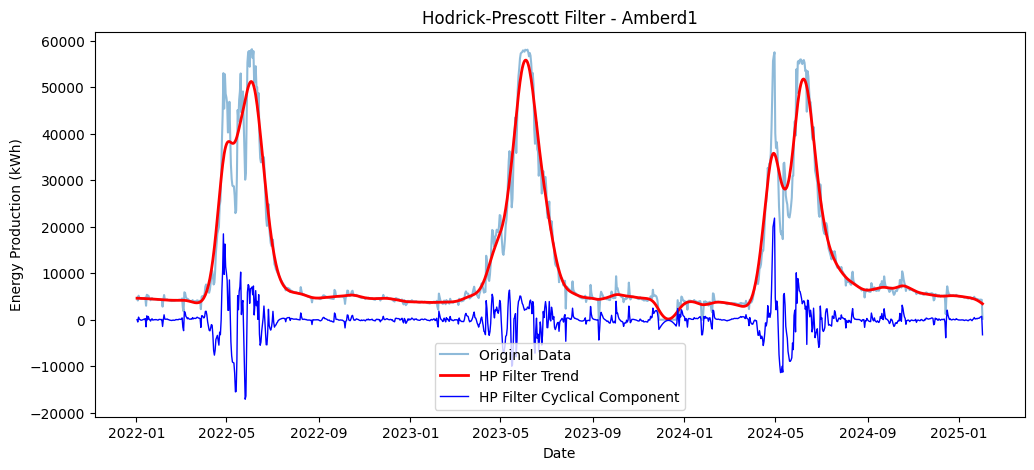

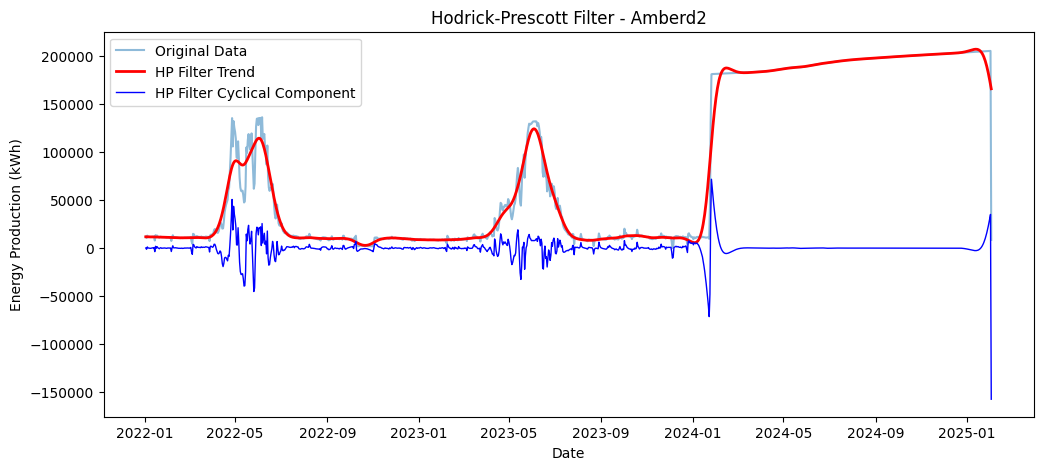

In [12]:
### Hodrick-Prescott Filter (Fixed & Stored in Residuals)
for station in df_daily["Station"].unique():
    station_data = df_daily[df_daily["Station"] == station]["Energy Production (kWh)"].dropna()

    station_data = station_data.sort_index()

    cycle, trend = hpfilter(station_data, lamb=1600)
    hp_residuals_series = pd.Series(cycle, index=station_data.index)

    df_residuals.loc[df_residuals["Station"] == station, "HP_Residuals"] = (
        hp_residuals_series.reindex(df_residuals[df_residuals["Station"] == station].index).values
    )

    plt.figure(figsize=(12, 5))
    plt.plot(station_data.index, station_data, label="Original Data", alpha=0.5)
    plt.plot(station_data.index, trend, label="HP Filter Trend", color="red", linewidth=2)
    plt.plot(station_data.index, cycle, label="HP Filter Cyclical Component", color="blue", linewidth=1)

    plt.title(f"Hodrick-Prescott Filter - {station}")
    plt.xlabel("Date")
    plt.ylabel("Energy Production (kWh)")
    plt.legend()
    plt.show()

In [13]:
# Summary statistics for residuals
residual_stats = df_residuals.drop(columns=["Station"]).describe().T  # Remove "Station" column for analysis
print(residual_stats)

                    count          mean            std           min  \
STL_Residuals      3383.0 -7.940404e+01    7582.366654 -1.967675e+05   
Diff_Residuals     3383.0 -5.524492e+00    8006.483719 -1.967223e+05   
HP_Residuals       3383.0 -2.356623e-09   10659.918868 -1.573097e+05   
Fourier_Residuals  3383.0  4.311728e+04   63860.172978 -4.788715e-11   
Wavelet_Residuals  3383.0  4.427879e+04  162191.656913 -2.769084e+05   

                            25%           50%            75%            max  
STL_Residuals       -202.519539     -1.835402     198.394856   59662.030705  
Diff_Residuals      -478.730000    -17.640000     230.580000  101951.500000  
HP_Residuals        -658.571188      6.726087     754.855733   77265.868392  
Fourier_Residuals   7710.920000  12608.400000   39227.090000  250255.880000  
Wavelet_Residuals -48699.604906  -6940.656052  122474.684382  495953.826017  


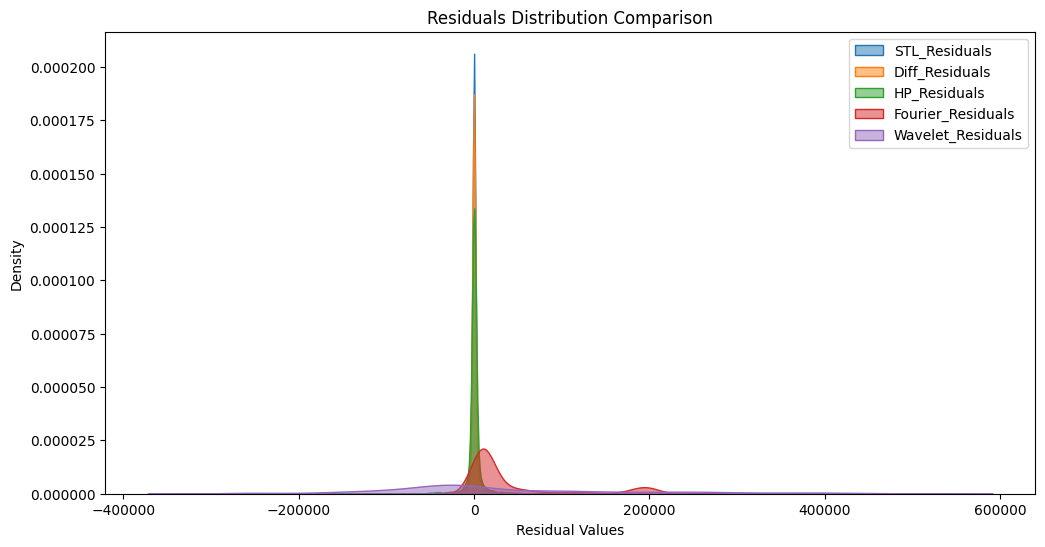

In [14]:
plt.figure(figsize=(12, 6))

# KDE for each residual method
for column in ["STL_Residuals", "Diff_Residuals", "HP_Residuals", "Fourier_Residuals", "Wavelet_Residuals"]:
    sns.kdeplot(df_residuals[column].dropna(), label=column, fill=True, alpha=0.5)

plt.title("Residuals Distribution Comparison")
plt.xlabel("Residual Values")
plt.ylabel("Density")
plt.legend()
plt.show()

<Figure size 1200x800 with 0 Axes>

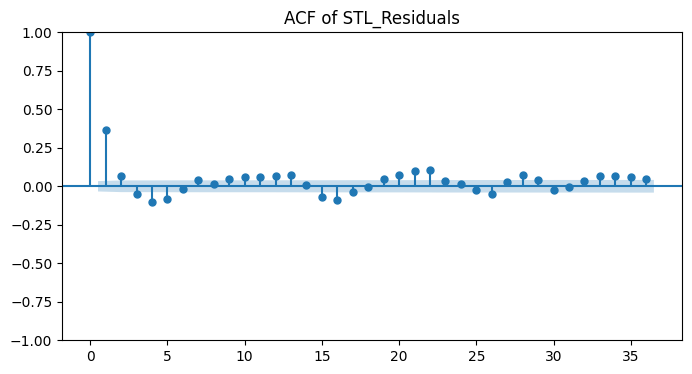

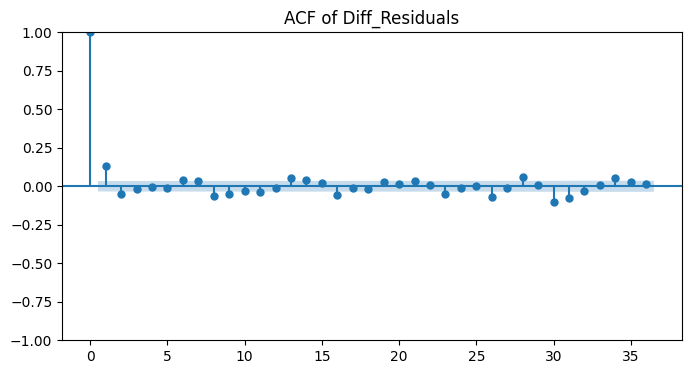

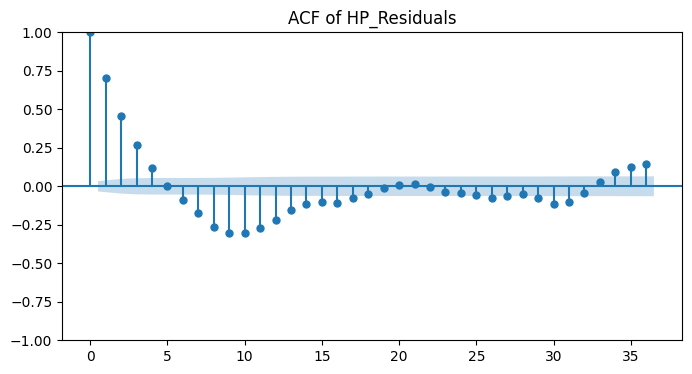

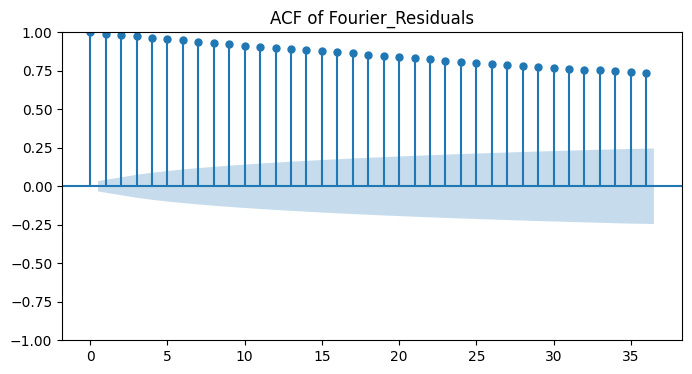

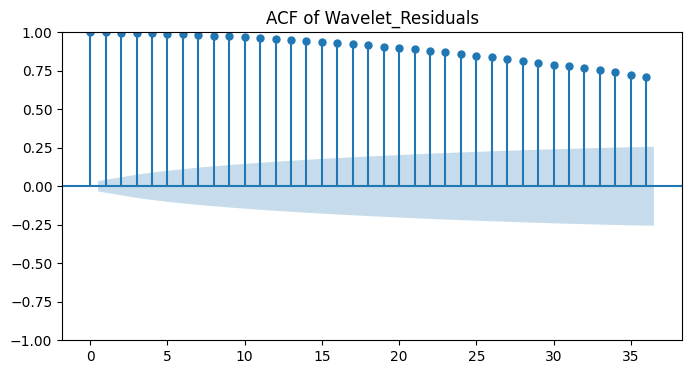

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12, 8))

# ACF for each residual method
for column in ["STL_Residuals", "Diff_Residuals", "HP_Residuals", "Fourier_Residuals", "Wavelet_Residuals"]:
    fig, ax = plt.subplots(figsize=(8, 4))
    plot_acf(df_residuals[column].dropna(), ax=ax, title=f"ACF of {column}")
    plt.show()


In [16]:
from statsmodels.tsa.stattools import adfuller

for column in ["STL_Residuals", "Diff_Residuals", "HP_Residuals", "Fourier_Residuals", "Wavelet_Residuals"]:
    residuals = df_residuals[column].dropna()
    adf_result = adfuller(residuals)
    print(f"ADF Test for {column}: p-value = {adf_result[1]:.5f}")


ADF Test for STL_Residuals: p-value = 0.00000
ADF Test for Diff_Residuals: p-value = 0.00000
ADF Test for HP_Residuals: p-value = 0.00000
ADF Test for Fourier_Residuals: p-value = 0.00270
ADF Test for Wavelet_Residuals: p-value = 0.00000


In [20]:
df_residuals = df_residuals[df_residuals.index.isin(df_daily.index)]


In [22]:
print(df_stl_cleaned.head())  
print(df_residuals.index.equals(df_daily.index))  


             Station  Energy Production (kWh)  Diff_Production
DateTime                                                      
2022-01-02  Amberd 3                 13652.38           959.00
2022-01-03  Amberd 3                 12507.04         -1145.34
2022-01-04  Amberd 3                 14888.44          2381.40
2022-01-05  Amberd 3                 13641.18         -1247.26
2022-01-06  Amberd 3                 13375.60          -265.58
True


In [26]:
save_path = "/Users/elvinanosrati/Capstone/energy-production-analysis/"

df_stl_cleaned = df_daily.copy()
df_stl_cleaned["Energy Production (kWh)"] = df_residuals["STL_Residuals"]
df_stl_cleaned = df_stl_cleaned[["Station", "Energy Production (kWh)"]]
df_stl_cleaned.to_csv(f"{save_path}STL_Energy_Production.csv", index=True)

df_hp_cleaned = df_daily.copy()
df_hp_cleaned["Energy Production (kWh)"] = df_residuals["HP_Residuals"]
df_hp_cleaned = df_hp_cleaned[["Station", "Energy Production (kWh)"]]
df_hp_cleaned.to_csv(f"{save_path}HP_Energy_Production.csv", index=True)

print("STL and HP datasets saved successfully in the Git repository!")

STL and HP datasets saved successfully in the Git repository!


In [18]:
df_daily.to_csv("df_daily.csv")